# Análises COVID-19 - Bootcamp Unimed-BH DIO

**Aluno:** Mateus de Paula Miranda

**Professor:** Dr. Neylson Crepalde

Vamos analisar as séries temporais sobre a contaminação do vírus COVID-19 pelo mundo. 

Os dados utilizados serão da plataforma Kaggle: [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset)

## 01 - Bibliotecas e Dependências

In [1]:
# Instalando dependências com pip
!pip3 install --upgrade plotly nbformat ipython statsmodels pmdarima

# Facebook Prophet
# conda install -c conda-forge prophet -y
# ou
# !pip3 install prophet
# !pip3 install pystan==2.19.1.1
# !pip3 install fbprophet


In [14]:
# visualização e análise
from datetime import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re

## para modelagem
from prophet import Prophet
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose


## 02 - Dataset

Agora, vamos importar os dados. É importante já dizer no comando `pd.read_csv` quais são as colunas que serão "parseadas" como datas. O pandas possui métodos robustos para trabalhar com esse tipo de informação.

In [3]:
# importando os dados .csv pela url
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'

# observationdate e last update = tem q definir que esses campos são datas, evita que sejam importados como texto
df = pd.read_csv(url, parse_dates=['ObservationDate', 'Last Update'])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


Agora, vamos conferir os tipos das variáveis para verificar que as colunas foram corretamente importadas.

In [4]:
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

### *2.1 - Preparando o Dataset*

Nomes de colunas não devem ter letras maiúsculas e nem caracteres especiais. Vamos utilizar uma função que tire os caracteres especiais e coloque as letras em minúsculo. 

A biblioteca utilizada vai ser a [re — Regular expression operations](https://docs.python.org/3/library/re.html)

In [5]:
def corrige_colunas(col_name):
    # aqui substitui a / ou espaço vazio por nada 
    # lower vai padronizar colocando as letras em minúsculos
    return re.sub(r"[/| ]", "", col_name).lower()

In [6]:
# corrigindo as letras do df 
df.columns = [corrige_colunas(col) for col in df.columns]

In [8]:
df.head()

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


## 3 - Análises Descritivas

Agora vamos começar a investigar as variáveis que temos à disposição. Sabemos que trata-se de séries temporais que estão divididas por estado. Para fazer qualquer análise, portanto, precisamos dividir os nossos dados esse "grão". 

Vamos verificar primeiro quantos estados temos informações para o Brasil.

In [9]:
# .loc = localizar
df.loc[df.countryregion == 'Brazil']

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
82,83,2020-01-23,NaN,Brazil,2020-01-23 17:00:00,0.0,0.0,0.0
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0


No caso do Brasil, não temos informação a nível de estado (valor NAN), apenas a nível do país. Então vamos verificar como está o comportamento dos casos confirmados no Brasil desde o primeiro caso confirmado, 26 de fevereiro.

### *3.1 - Casos confirmados*

In [10]:
# criando um dataset apenas com o Brasil e que os casos confirmados seja maior que zero
df_brasil = df.loc[(df.countryregion == 'Brazil') & (df.confirmed > 0)]

In [11]:
df_brasil

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0


#### Gráfico da evolução de casos confirmados

In [12]:
# px.line?

In [13]:
# gráfico é interativo, passndo o mouse por cima aparece os dados
px.line(df_brasil, 'observationdate', 'confirmed', 
        labels={'observationdate':'Data', 'confirmed':'Número de casos confirmados'},
       title='Casos confirmados no Brasil')

### *3.2 - Número de novos casos por dia*

In [16]:
# vamos implementar uma função para fazer a contagem de novos casos
# iloc - pega pelo indice, entao colocando iloc[x-1] pegamos o dia anterior
# subtraindo o dia de hoje pelo anterior temos os numero de casos confirmados apenas de hoje (novos)
# if x==0, é o primeiro que não necessariamente é novo e vamos contar a partir de 1 (segundo dia)
df_brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else df_brasil['confirmed'].iloc[x] - df_brasil['confirmed'].iloc[x-1],
    np.arange(df_brasil.shape[0])
))

/tmp/ipykernel_3910/3834511262.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# visualizando
px.line(df_brasil, x='observationdate', y='novoscasos', title='Novos casos por dia',
       labels={'observationdate': 'Data', 'novoscasos': 'Novos casos'})

O número de novos casos parece ser um excelente caso para modelagem. Será que conseguimos predizer quando o número de novos casos vai começar a cair?

### *3.3 - Número de Mortes*

In [18]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_brasil.observationdate, y=df_brasil.deaths, name='Mortes', mode='lines+markers',
              line=dict(color='red'))
)
# edita o layout
fig.update_layout(title='Mortes por COVID-19 no Brasil',
                   xaxis_title='Data',
                   yaxis_title='Número de mortes')
fig.show()

### *3.4 - Taxa de crescimento*

Vamos calcular a taxa de crescimento do COVID desde o primeiro caso.

taxa_media_crescimento = (presente/passado) ** (1/n) - 1

onde 1/n = número de dias

In [19]:
# data = dados
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)

    # se data_inicio for None, define como a última data disponível no dataset    
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    # retorna a taxa em porcentagem
    return taxa*100

In [20]:
# taxa de crescimento médio do COVID no Brasil em todo o período 
cresc_medio = taxa_crescimento(df_brasil, 'confirmed')
print(f"O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


### *3.4.1 - Taxa de Crescimento Deiária*

Agora, vamos observar o comportamento da **taxa de crescimento no tempo**. Para isso, vamos definir uma função para calcular a taxa de crescimento diária.

In [21]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)

    # a data fim vai ser necessáriamente a última    
    data_fim = data.observationdate.max()
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # taxa calculada de um dia para o outro
    taxas = list(map(
        # hoje - ontem / ontem -> quantos casos teve a mais hoje
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1) # de 1 pq precisa pegar do segundo dia, n+1 pq no range exclui o ultimo numero e qremos incluir
    ))
    return np.array(taxas)*100

In [22]:
tx_dia = taxa_crescimento_diaria(df_brasil, 'confirmed')

In [23]:
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [24]:
primeiro_dia = df_brasil.observationdate.loc[df_brasil.confirmed > 0].min()

# construindo o x: pegando do segundo ao último dia
px.line(x=pd.date_range(primeiro_dia, df_brasil.observationdate.max())[1:],
        y=tx_dia, title='Taxa de crescimento de casos confirmados no Brasil',
       labels={'y':'Taxa de crescimento', 'x':'Data'})

Enquanto a taxa estiver maior que zero quer dizer que os casos estão aumentando. Apenas quando a taxa for menor que zero é que os causos estão diminuindo.

A linha de crescimento parece que "diminui" ao longo dos dias, mas isso não é necessáriamente a realidade. Temos apresentado a proporção, por exemplo, no primeiro pico temos um crescimento de 100% porque a linha saiu de 0 até 100 casos. Nos outros dias podemos ter mais casos, mas se o valor for muito elevado do dia anterior, ex: 20.000, e aumentar para 22000, mesmo com um crescimento de 2000 casos a proporção vai ser de apenas 10% em relação ao dia anterior. 

## 4 - Predições

Vamos construir um modelo de séries temporais para prever os novos casos. Antes analisemos a série temporal.

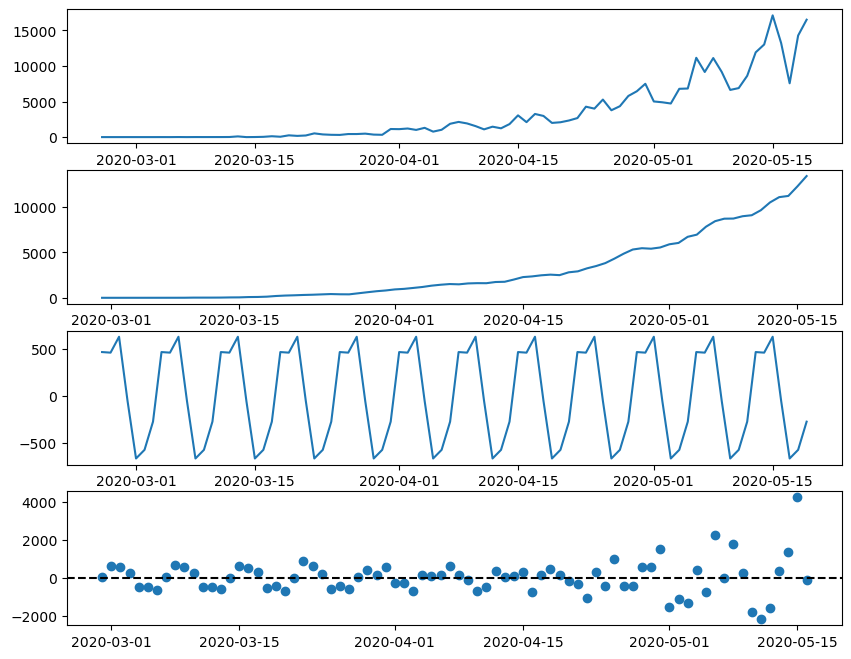

In [25]:
novoscasos = df_brasil.novoscasos
novoscasos.index = df_brasil.observationdate

res = seasonal_decompose(novoscasos)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

### *4.1 - Decompondo a série de confirmados*



In [26]:
confirmados = df_brasil.confirmed
confirmados.index = df_brasil.observationdate
confirmados

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Name: confirmed, Length: 84, dtype: float64

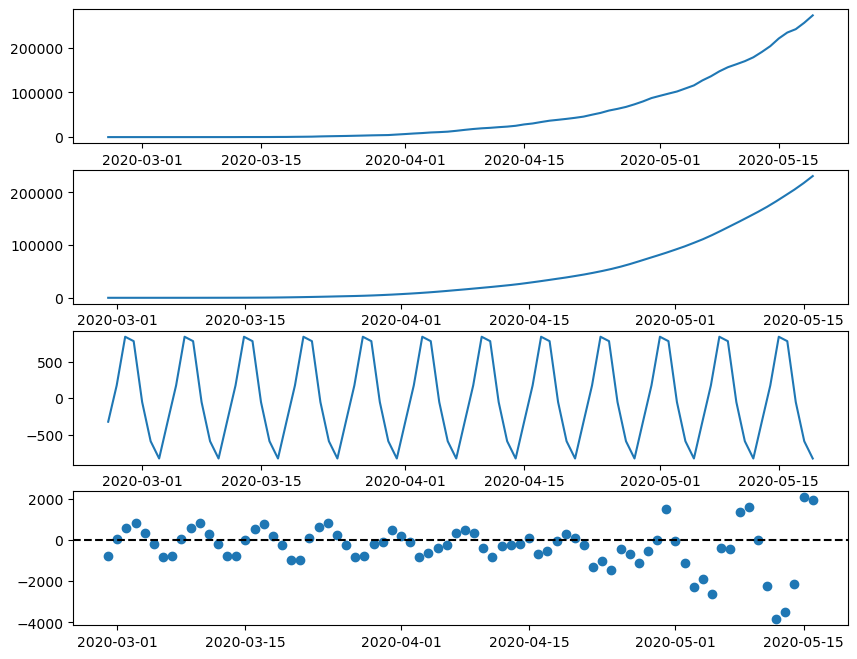

In [27]:
# fazendo a decomposição
res2 = seasonal_decompose(confirmados)

# criando os gráficos 
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
# 1 - casos observados
ax1.plot(res2.observed)
# 2 - tendência
ax2.plot(res2.trend)
# 3 - sazonalidade
ax3.plot(res2.seasonal)
# 4 - ruído
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

## *4.2 Predizendo o número de casos confirmados com um AUTO-ARIMA*

[ARIMA](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7) - Média Móvel Integrada Autoregressiva, tenta modelar o futuro baseado em valores do passado. Usa apenas a mesma séria para prever, não possui variáveis exógenas.

`pip3 install pmdarima`

In [28]:
modelo = auto_arima(confirmados)

In [29]:
pd.date_range('2020-05-01', '2020-05-19')

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', freq='D')

In [30]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observed'
))

# pegar o que aprendeu e vai prever a serie por cima (treinamento)
fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

# previsão de um mês pra frente (aplicar o que foi treinado)
fig.add_trace(go.Scatter(x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados para os próximos 15 dias',
                 yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()

## *4.2 - Forecasting com Facebook Prophet*

Modelo de crescimento, tentar prever qual vai ser o ponto de virado - curva "achatar".

<https://facebook.github.io/prophet/>

In [31]:
# Preprocessamentos
# preparando os dados
# vai tirar o index para não atrapalhar (deixando só duas colunas)
# e vai pegar do inicio aos cinco últimos para testar
train = confirmados.reset_index()[:-5]
# cinco últimos para teste
test = confirmados.reset_index()[-5:]

# renomeia colunas
# obrigações da biblioteca, colocar ds e y
train.rename(columns={"observationdate":"ds", "confirmed":"y"}, inplace=True) 
test.rename(columns={"observationdate":"ds", "confirmed":"y"}, inplace=True)
test = test.set_index("ds")
test = test['y']

# definir o modelo de crescimento
# regressão lógiscas estima a função sigmoide
profeta = Prophet(growth="logistic", changepoints=['2020-03-21', '2020-03-30', '2020-04-25', '2020-05-03', '2020-05-10'])

# o modelo de crescimento trabalha com ponto máximo, ou seja, cenário que toda a populção vai ser contamida
# pop = população brasileira
# pop = 1000000
pop = 211463256 #https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php
train['cap'] = pop

##### INICIO - treinamento e previsão #####

# treina o modelo
profeta.fit(train)

# construindo previsões para o futuro
# periods - prever 200 dias para sempre
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast =  profeta.predict(future_dates)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(title='Predições de casos confirmados no Brasil')
fig.show()

De acordo com o modelo de predição e os dados usados a curva so vai "achatar" a partir de Novembro de 2020. Isso, claro, se nenhuma medida for tomada. Afinal esse modelo está se baseando apenas no dataset sem variáveis exogénas.

## Erros e Bugs

Tive alguns erros para instalar a biblioteca Facebook Prophet:
    1. eles mudaram o nome da biblioteca de fbprophet para propeht, então sempre dar uma olhada no site oficial de cada biblioteca [Facebook Prophet](https://facebook.github.io/prophet/)
    2. uso a distribuição linux mint e o miniconda para meus projetos de data science. É uma boa prática sempre atualizar a distro e o pacote conda antes de começar os projetos.